# Description

# Environment

## Library Imports

In [8]:
### Setup
library(readr)
library(data.table)
library(reshape)
library(ggplot2)
library(gridExtra)
system("ls '/home/phuc/Desktop/Work/Data Sience/kaggle_competition/SafeDirverPrediction/data/raw'")
options(repr.plot.width = 6, repr.plot.height = 3)
df <- read_csv("/home/phuc/Desktop/Work/Data Sience/kaggle_competition/SafeDirverPrediction/data/raw/train.csv")
class(df) <- "data.frame"
### Plotting functions
plot_one_way <- function(df,lines, bars = NULL, factor){
  ## If bars not given, do count
  if (is.null(bars)){
    bars <- "Count"
    df$Count <- 1
  }
  
  ## Check df contains lines, bars, factor
  if (prod(c(lines,bars,factor)%in%names(df))==0){
    stop("lines, bars and factor not all present in df")
  }
  
  if (!is.factor(df[,factor])){
    df[,factor] <- as.factor(df[,factor])
  }
  
  ## Weight lines by bars for weighted average
  df[,lines] <- df[,lines] * df[,bars]
  
  ## Crunch lines (1 row per factor level and line)
  df.melt <- melt(df [,c(factor,lines)],id=factor)
  df.crunch <- as.data.frame(data.table(df.melt)[,.(value=sum(value))
                                                 ,by = c(factor,"variable")])
  
  ## Crunch weight (1 row per factor level)
  df$wt <- df[,bars]
  df.crunch.wt <- as.data.frame(data.table(df)[,.(wt=sum(wt))
                                               ,by = c(factor)])
  
  ## Join weight to line data
  df.crunch$wt <- df.crunch.wt[match(df.crunch[,factor],df.crunch.wt[,factor]),"wt"]
  
  ## Average response
  line.avg <- sum(df.crunch$value)/sum(df.crunch$wt)
  
  ## Convert value to average
  df.crunch$value <- df.crunch$value/df.crunch$wt
  
  ## Rescale weight so that max == line.avg
  df.crunch.wt$wt_rescaled <- df.crunch.wt$wt * line.avg / max(df.crunch.wt$wt)
  
     ## Plot a chart
  plot.one_way<-ggplot(df.crunch.wt, aes_string(x=factor,y="wt_rescaled",group=1))+
    geom_bar(stat="identity",fill="yellow",colour="white",alpha=0.3)+
    geom_line(data=df.crunch,aes_string(x=factor,y="value",colour="variable",group="variable"))+
    geom_point(data=df.crunch,aes_string(x=factor,y="value",colour="variable",group="variable"))+
    theme(axis.text.x = element_text(angle = 60, hjust = 1))+
    labs(y = "value" )+ggtitle(factor)
  
  return(plot.one_way)
}

plot_two_way <- function(df,line, bars = NULL, factor1, factor2, rescale = F){
  ## If bars not given, do count
  if (is.null(bars)){
    bars <- "Count"
    df$Count <- 1
  }
  
  ## Check df contains lines, bars, factor
  if (prod(c(line,bars,factor1,factor2)%in%names(df))==0){
    stop("lines, bars and factor not all present in df")
  }
  
  if (!is.factor(df[,factor1])){
    df[,factor1] <- as.factor(df[,factor1])
  }
  
  if (!is.factor(df[,factor2])){
    df[,factor2] <- as.factor(df[,factor2])
  }
  
  ## Weight lines by bars for weighted average
  df[,line] <- df[,line] * df[,bars]
  
  ## Crunch data
  df$wt <- df[,bars]
  df$value <- df[,line]
  df.crunch <- as.data.frame(data.table(df)[,.(value=sum(value),
                                               wt=sum(wt))
                                            ,by = c(factor1,factor2)])
  
  ## Crunch weight 1-way
  df.crunch.1way <- as.data.frame(data.table(df)[,.(wt=sum(wt))
                                                 ,by = c(factor1)])
  
  ## Convert value to average
  df.crunch$value <- df.crunch$value/df.crunch$wt
  
  ## Rescale
  if (rescale){
    df.crunch$lp <- ifelse(df.crunch$value%in%c(0,1),0,log(df.crunch$value/(1-df.crunch$value)))
    lm.noint <- lm(as.formula(paste("lp~",factor1,"+",factor2)),data = df.crunch,weights = df.crunch$wt)
    df.crunch$lp_noint <- predict(lm.noint,newdata = df.crunch)
    df.crunch$lp_int <- df.crunch$lp - df.crunch$lp_noint
    df.crunch$value <- exp(df.crunch$lp_int)/(1+exp(df.crunch$lp_int))
  }
  
  ## Average response
  line.avg <- sum(df.crunch$value*df.crunch$wt)/sum(df.crunch$wt)
  
  ## Rescale weight so that max == line.avg
  df.crunch$wt_rescaled <- df.crunch$wt * line.avg / max(df.crunch.1way$wt)
  
  df.crunch <- df.crunch[order(df.crunch[,factor1],df.crunch[,factor2]),]
    
    chart.title <- paste(factor1,"by",factor2)
    if (rescale){
        chart.title <- paste(chart.title,"(rescaled)")
    }
    
  ## Plot a chart
  plot.two_way<-ggplot(df.crunch)+
    geom_bar(stat="identity", aes_string(x=factor1,y="wt_rescaled",fill=factor2,group=factor2),col="white",alpha=0.3)+
    geom_line(aes_string(x=factor1,y="value",colour=factor2,group=factor2))+
    geom_point(aes_string(x=factor1,y="value",colour=factor2,group=factor2))+
    theme(axis.text.x = element_text(angle = 60, hjust = 1))+
    labs(y = "value" ) + ggtitle(chart.title)
  
  return(plot.two_way)
}

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



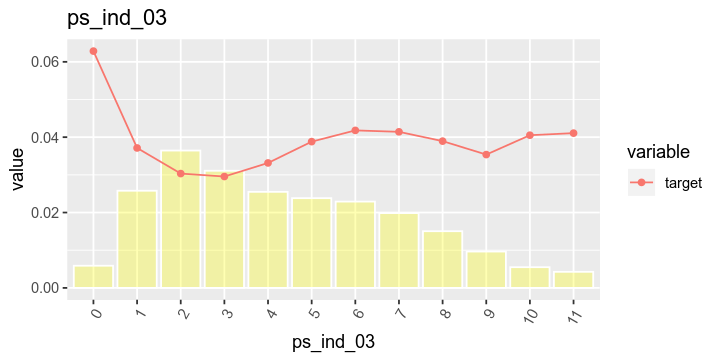

In [7]:
plot_one_way(df=df,lines="target",factor="ps_ind_03")